In [245]:
import tensorflow
import pandas as pd
import time
import numpy as np
import pylab as plt
import multiprocessing as mp
import statistics
from statistics import mean

import librosa
from librosa import feature
from glob import glob
import os

from sklearn.preprocessing import StandardScaler, OneHotEncoder

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Conv2D, Activation
from tensorflow.keras.callbacks import Callback
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
min_max_scaler = preprocessing.MinMaxScaler()

encoder = OneHotEncoder()

In [246]:
rootdir = '/Users/abhishekvaidyanathan/Desktop/NNDL-project/audio-files'
audio_files = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        audio_files.append(os.path.join(subdir, file))
audio_files = audio_files[1:]

In [247]:
dict_actors = {}
for audio_file in audio_files:
    try :
        if (len(dict_actors[audio_file[-33:-25]])>0):
            dict_actors[audio_file[-33:-25]].append(audio_file)
    except:
        dict_actors[audio_file[-33:-25]] = []
        dict_actors[audio_file[-33:-25]].append(audio_file)

In [248]:
data = pd.DataFrame(columns = ['Actor','Modality','Vocal_channel','Emotion','Emotional_intensity','Statement','Repetion','Gender','Audio_file'])

In [249]:
def get_gender(value):
    if(int(value)%2==0):
        return 1
    else :
        return 0

for keys in dict_actors:
    for files in dict_actors[keys]:
        data.loc[len(data)] = [keys,int(files[-24:-22]),int(files[-21:-19]),int(files[-18:-16]),int(files[-15:-13]),int(files[-12:-10]),int(files[-9:-7]),get_gender(files[-6:-4]),files]

In [311]:
def get_feature_vector(y, sr):
    feature_vector = []
    
    # multi-dim features
    feature_vector.extend(np.mean(feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1))
    feature_vector.extend(np.mean(feature.chroma_stft(y=y, sr=sr), axis=1))
    feature_vector.extend(np.mean(feature.spectral_contrast(y=y, sr=sr), axis=1))
    feature_vector.extend(np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr),axis=1))
    feature_vector.extend(np.mean(librosa.feature.melspectrogram(y=y, sr=sr), axis=1))
    
    # single-dim features with special requirements
    feature_vector.append(np.mean(feature.rms(y=y)))
    feature_vector.append(np.mean(feature.zero_crossing_rate(y=y)))
    feature_vector.extend([np.mean(x) for x in librosa.piptrack(y=y, sr=sr)])
    
    # single-dim features
    feat_list = [
        librosa.onset.onset_strength,
        feature.spectral_rolloff,
        feature.melspectrogram,
        feature.spectral_centroid,
        feature.spectral_bandwidth
    ]
    
    for temp_func in feat_list:
        feature_vector.append(np.mean(temp_func(y=y, sr=sr)))
    
    return feature_vector

In [ ]:
audio_features = []
for i in range(data.shape[0]):
   y , sr = librosa.load(data.iloc[i]['Audio_file'],sr=None)
   feature_vector = get_feature_vector(y, sr)
   audio_features.append(feature_vector)

In [ ]:
data_features = data.copy()
data_features = data_features.drop("Audio_file",axis=1)
data_features['librosa'] = audio_features

In [ ]:
features = pd.DataFrame(data_features['librosa'].values.tolist())
labels = data['Emotion']
features_values = features.values

In [ ]:
features_scaled_values = min_max_scaler.fit_transform(features_values)
features_normalised = pd.DataFrame(features_scaled_values)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_normalised, labels, test_size=0.30, random_state=42)

In [ ]:
X_train.to_csv('./SER_data/X_train.csv', index=False)
X_test.to_csv('./SER_data/X_test.csv', index=False)
y_train.to_csv('./SER_data/y_train.csv', index=False)
y_test.to_csv('./SER_data/y_test.csv', index=False)

In [398]:
X_train = pd.read_csv("./SER_data/X_train.csv")
X_test = pd.read_csv("./SER_data/X_test.csv")
y_train = pd.read_csv("./SER_data/y_train.csv")
y_test = pd.read_csv("./SER_data/y_test.csv")

In [212]:
X_train_cnn = np.expand_dims(X_train,axis=2)
X_test_cnn = np.expand_dims(X_test,axis=2)
y_train_cnn = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test_cnn = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

In [543]:
def cnn_layers(no_folds,no_epochs,batch_size,X_train,y_train,X_test,y_test,epoch_times_dict):  

  kf = KFold(n_splits=no_folds,random_state=None, shuffle=False)
  KFold(n_splits=no_folds, random_state=None, shuffle=False)
  history_results = []

  model = Sequential()

  model.add(Conv1D(256, 5, padding='same', input_shape=(X_train.shape[1],1)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=(8)))
  model.add(Dropout(0.2))

  model.add(Conv1D(128, 5,padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=(4)))
  model.add(Dropout(0.1))

  # model.add(Conv1D(64, 5,padding='same'))
  # model.add(Activation('relu'))
  # # model.add(MaxPooling1D(pool_size=(2)))
  # model.add(Dropout(0.1))

  model.add(Flatten())
  # model.add(Dense(128))
  # model.add(Dropout(0.2))
  # model.add(BatchNormalization())
  model.add(Dense(64))
  model.add(Dropout(0.2))
  model.add(Dense(8))
  model.add(Activation('softmax'))

  print(model.summary())

  # set callbacks
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                  factor=0.5, patience=4, 
                                                  verbose=1, mode='max', 
                                                  min_lr=0.001)

  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=42,
                                                verbose=1)

  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('/Users/abhishekvaidyanathan/Desktop/NNDL-saved-models/','all_model_weights.hdf5'), 
                                                        save_weights_only=True, 
                                                        monitor='val_accuracy', 
                                                        mode='max', 
                                                        save_best_only=True)

  model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=2,
                use_multiprocessing=False,
                callbacks = [model_checkpoint],
                validation_data=(X_test, y_test))

  history_results.append(history)

  return [history_results, model]

In [544]:
Batch_sizes = [16]
model_results = {}
epoch_times_dict = {}
for size in Batch_sizes:
  history = cnn_layers(2,150,size,X_train_cnn,y_train_cnn,X_test_cnn,y_test_cnn,epoch_times_dict)
  model_results[size] = history[0]

Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_187 (Conv1D)          (None, 175, 256)          1536      
_________________________________________________________________
activation_192 (Activation)  (None, 175, 256)          0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 175, 256)          1024      
_________________________________________________________________
max_pooling1d_163 (MaxPoolin (None, 21, 256)           0         
_________________________________________________________________
dropout_241 (Dropout)        (None, 21, 256)           0         
_________________________________________________________________
conv1d_188 (Conv1D)          (None, 21, 128)           163968    
_________________________________________________________________
activation_193 (Activation)  (None, 21, 128)        

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


63/63 - 2s - loss: 3.4403 - accuracy: 0.1607 - val_loss: 2.1058 - val_accuracy: 0.0810
Epoch 2/150
63/63 - 1s - loss: 2.7179 - accuracy: 0.1964 - val_loss: 2.1422 - val_accuracy: 0.0764
Epoch 3/150
63/63 - 1s - loss: 2.5216 - accuracy: 0.2242 - val_loss: 2.1730 - val_accuracy: 0.1435
Epoch 4/150
63/63 - 1s - loss: 2.4862 - accuracy: 0.2192 - val_loss: 2.1680 - val_accuracy: 0.1551
Epoch 5/150
63/63 - 1s - loss: 2.2833 - accuracy: 0.2688 - val_loss: 2.1088 - val_accuracy: 0.1505
Epoch 6/150
63/63 - 1s - loss: 2.2388 - accuracy: 0.2718 - val_loss: 2.0222 - val_accuracy: 0.1806
Epoch 7/150
63/63 - 1s - loss: 2.2230 - accuracy: 0.2500 - val_loss: 1.9692 - val_accuracy: 0.2222
Epoch 8/150
63/63 - 1s - loss: 2.1203 - accuracy: 0.2609 - val_loss: 1.8677 - val_accuracy: 0.2523
Epoch 9/150
63/63 - 1s - loss: 2.1467 - accuracy: 0.2550 - val_loss: 1.8114 - val_accuracy: 0.2778
Epoch 10/150
63/63 - 1s - loss: 2.0497 - accuracy: 0.2758 - val_loss: 1.7974 - val_accuracy: 0.2708
Epoch 11/150
63/63 - 

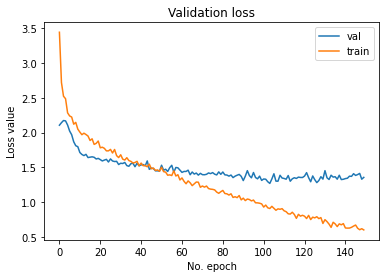

In [549]:
plt.plot(model_results[16][0].history['val_loss'])
plt.plot(model_results[16][0].history['loss'])
plt.title('Validation loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(['val', 'train'], loc='upper right')
plt.show()

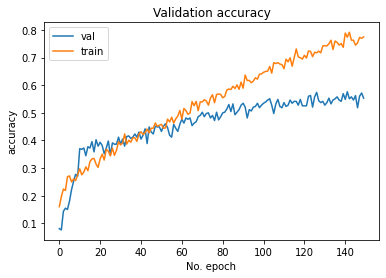

In [550]:
plt.plot(model_results[16][0].history['val_accuracy'])
plt.plot(model_results[16][0].history['accuracy'])
plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(['val', 'train'], loc='upper left')
plt.show()

In [547]:
pred_test = history[1].predict(X_test_cnn)
y_pred = encoder.inverse_transform(pred_test)
y_true = encoder.inverse_transform(y_test_cnn)

In [548]:
print(classification_report(y_pred,y_true))

              precision    recall  f1-score   support

           1       0.41      0.29      0.34        42
           2       0.63      0.55      0.59        66
           3       0.48      0.64      0.55        45
           4       0.32      0.53      0.40        32
           5       0.56      0.69      0.62        51
           6       0.64      0.52      0.57        67
           7       0.59      0.52      0.55        64
           8       0.71      0.65      0.68        65

    accuracy                           0.55       432
   macro avg       0.54      0.55      0.54       432
weighted avg       0.57      0.55      0.55       432

